# Plan-and-Execute
This notebook shows how to create a 'plan-and-execute' style agent. This is heavily inspired by the Plan-and-Solve paper as well as the Baby-AGI project

The idea is to come up with a multi-step plan, and then go through that plan one item at a time. After accomplishing a particular task, you can then revisit the plan and modify as appropriate.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Plan-and-execute'

In [3]:
import re
import os
import json
import base64
import asyncio
import platform
import requests
import operator
import playwright
import numpy as np
import pandas as pd
import datetime as dt

from enum import Enum
from typing import List
from typing import Dict
from typing import Tuple
from typing import Union
from typing import Literal
from typing import Optional
from typing import Annotated
from typing import TypedDict
from operator import itemgetter

from IPython import display
from IPython.display import HTML
from IPython.display import Image

from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.prebuilt import create_react_agent

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_core.messages import BaseMessage
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.chat import ChatMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain_core.messages.function import FunctionMessage
from langchain_core.prompts.image import ImagePromptTemplate

from langchain_core.pydantic_v1 import Field
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

from langchain_core.runnables.graph import CurveStyle
from langchain_core.runnables.graph import NodeColors
from langchain_core.runnables.graph import MermaidDrawMethod

from langchain import hub
from langchain.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
tools = [TavilySearchResults(max_results=3)]

In [5]:
prompt = hub.pull('wfh/react-agent-executor')
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


In [6]:
llm = ChatOpenAI(model='gpt-4o')
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

In [7]:
agent_executor.invoke({'messages': [('user', 'who is the winner of the us open')]})

{'messages': [HumanMessage(content='who is the winner of the us open', id='d32a438c-dd92-4e64-b8e0-dea34937401d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1EYfnZqFP45BkRyoYlwpcvCg', 'function': {'arguments': '{"query":"winner of the US Open 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 93, 'total_tokens': 118}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_43dfabdef1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e80c2691-b2e2-49f9-a76f-e29e7306946b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'winner of the US Open 2023'}, 'id': 'call_1EYfnZqFP45BkRyoYlwpcvCg'}]),
  ToolMessage(content='[{"url": "https://www.sportingnews.com/us/golf/news/us-open-2023-live-scores-results-leaderboard/jbmxrpro5jc37drgq8e2lehn", "content": "Sixth hole may be one to watch in Round 4, with the hole location for Round 4 in a pretty d

In [8]:
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [9]:
class Plan(BaseModel):
    steps: List[str] = Field(description='different steps to follow, should be in sorted order')

In [11]:
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''For the given objective, come up with a simple step by step plan. This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.'''
        ),
        ('placeholder', '{messages}')
    ]
)
planner = planner_prompt | ChatOpenAI(model='gpt-4o', temperature=0).with_structured_output(schema=Plan)

In [13]:
planner.invoke({'messages': [('user', 'what is the hometown of the current Australia open winner?')]})

Plan(steps=['Identify the current winner of the Australian Open.', 'Determine the hometown of the identified winner.'])

In [14]:
class Response(BaseModel):
    response: str

class Act(BaseModel):
    action: Union[Response, Plan] = Field(description='Action to perform. If you want to respond to user, use Response. If you need to further use tools to get the answer, use Plan.')

In [15]:
replanner_prompt = ChatPromptTemplate.from_template(
'''For the given objective, come up with a simple step-by-step plan. This plan should have involve individual tasks, that if executed correctly will yield the correct answer. 
Do not add any superfluous steps. The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps. 

Your objective was this: 
{input}

Your original plan was this: 
{plan}

You have currently done the following steps: 
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. 
Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. 
Do not return previously done steps as part of the plan.
''')

In [16]:
replanner = replanner_prompt | ChatOpenAI(model='gpt-4o', temperature=0).with_structured_output(schema=Act)

In [21]:
async def execute_step(state: PlanExecute):
    plan = state['plan']
    plan_str = '\n'.join(f'{i + 1}. {step}' for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f'''For the following plan: {plan_str}\n\nYou are tasked with executing step {1}, {task}.'''
    print(task_formatted)
    agent_response = await agent_executor.ainvoke({'messages': [('user', task_formatted)]})
    return {'past_steps': (task, agent_response['messages'][-1].content)}

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({'objective': [('user', state['input'])]})
    return {'plan': plan.steps}

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {'response': output.action.response}
    else:
        return {'plan': output.action.steps}

def should_end(state: PlanExecute) -> Literal['agent', '__end__']:
    if 'response' in state and state['response']:
        return END
    else:
        return 'agent'

In [22]:
workflow = StateGraph(PlanExecute)
workflow.add_node('planner', plan_step)
workflow.add_node('agent', execute_step)
workflow.add_node('replan', replan_step)
workflow.set_entry_point('planner')
workflow.add_edge('planner', 'agent')
workflow.add_edge('agent', 'replan')
workflow.add_conditional_edges(
    'replan',
    should_end
)

app = workflow.compile()

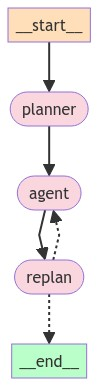

In [23]:
display.display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [24]:
config = {'recursion_limit': 50}
inputs = {'input': 'what is the hometown of the 2024 Australia open winner?'}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != '__end__':
            print(v)

{'plan': ['Identify the objective clearly.', 'Break down the objective into smaller, manageable tasks.', 'Arrange the tasks in a logical sequence.', 'Ensure each task has all the necessary information to be executed independently.', 'Verify that the final task yields the correct answer.']}
For the following plan: 1. Identify the objective clearly.
2. Break down the objective into smaller, manageable tasks.
3. Arrange the tasks in a logical sequence.
4. Ensure each task has all the necessary information to be executed independently.
5. Verify that the final task yields the correct answer.

You are tasked with executing step 1, Identify the objective clearly..
{'past_steps': ('Identify the objective clearly.', "To identify the objective clearly, it's important to understand the overall goal of the plan. Here are some questions to help pinpoint the objective:\n\n1. **What is the desired outcome?**\n   - Clearly state what you want to achieve by the end of this plan.\n\n2. **Why is this ob